In [1]:
import numpy as np
import matplotlib
import os
import cellpose
import tifffile
from cellpose import plot
from tqdm.notebook import tqdm
import glob
import matplotlib.pyplot as plt

import graphsonchip
import graphsonchip.analyse

from random import random
import random
import skimage.color
from skimage.segmentation import find_boundaries

## Extracting the cell properties

In [3]:
PATH = '/home/pub/Documents/mnt/Gustave/light_sheet/Peixoto/test_seg'

reconstructed_image = np.load(os.path.join(PATH,'210216_4_individual_tile_1_recontructed.npy'))
img = tifffile.imread(os.path.join(PATH,'210216_4_individual_tile_1.tif' ))

img = np.swapaxes(img, 1,3)

In [4]:
img_test_seg = np.concatenate((img, reconstructed_image[..., np.newaxis].astype(int)), axis =3)

del img
del reconstructed_image

In [5]:
prop = graphsonchip.analyse.cell_property_extraction.get_cell_properties(
    img_test_seg,
    nuclei_channel = 4,
    analyze_fluo_channels = True,
    fluo_channel_analysis_method = 'basic',
    cell_geometry_properties = False,
    radius = 15,
    labeled_voronoi_tesselation = False,
    percentile = 99
    )

nuclei properties extracted


We see what probably is some spurious nuclei detection, We choose to remove these nuclei from the analysis.

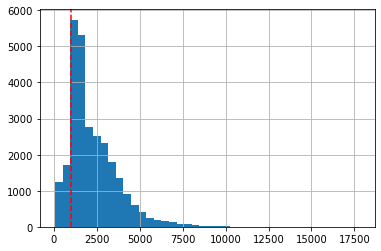

In [6]:
prop.area.hist(bins = 40)
plt.axvline(c = 'r', 
            linestyle = '--',
            x=1000)

### General sample analysis

We need to seperate the population according to whether or not the cells are positive/negative to the different markers added. We do this by thresholding the channel from a given livel.

In [20]:
def cell_catigorizer(dataframe, channel, threshold):
    
    dataframe[channel + '_state'] = (dataframe[channel] > threshold).astype(int)
    
    return dataframe

In [25]:
pertinent_channels = ['mean_intensity_1','mean_intensity_2','mean_intensity_3']

for channel in pertinent_channels:
    
    prop = cell_catigorizer(prop, channel, 200)

prop

,label,z,x,y,area,mean_intensity_0,mean_intensity_1,mean_intensity_2,mean_intensity_3,cell_type,mean_intensity_1_state,mean_intensity_2_state,mean_intensity_3_state
0,2,11.0,2.0,66.0,760.0,600.967105,60.860526,68.802632,95.852632,0,0,0,0
1,3,10.0,2.0,104.0,1167.0,602.921165,25.294773,29.167095,121.562982,0,0,0,0
2,4,7.0,1.0,172.0,588.0,567.096939,30.886054,28.215986,86.307823,0,0,0,0
3,5,1.0,1.0,235.0,190.0,946.247368,20.052632,157.189474,241.563158,0,0,0,1
4,6,3.0,3.0,301.0,971.0,1089.538620,33.221421,98.530381,258.033986,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28960,28961,NaN,NaN,NaN,NaN,451.000000,0.000000,124.000000,29.000000,0,0,0,0
28961,28962,NaN,NaN,NaN,NaN,752.000000,0.000000,0.000000,261.000000,0,0,0,1
28962,28963,NaN,NaN,NaN,NaN,1047.200000,164.800000,648.800000,168.200000,2,0,1,0
28963,28964,NaN,NaN,NaN,NaN,1107.666667,34.333333,62.166667,978.833333,1,0,0,1


In [10]:
from sklearn.cluster import KMeans

X = np.array(prop[['mean_intensity_1', 'mean_intensity_2', 'mean_intensity_3']].values)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

prop['cell_type'] = kmeans.labels_

/home/pub/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


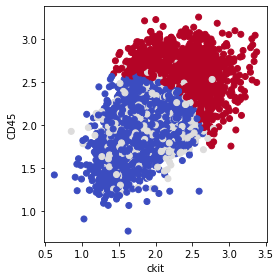

In [24]:
fig, ax = plt.subplots(figsize = (4,4))

plt.scatter(np.log10(prop['mean_intensity_1']), 
            np.log10(prop['mean_intensity_2']), 
            marker='o', 
            c=prop['cell_type'], 
            cmap=plt.cm.coolwarm)

ax.set_xlabel('ckit')
ax.set_ylabel('CD45')

plt.tight_layout()

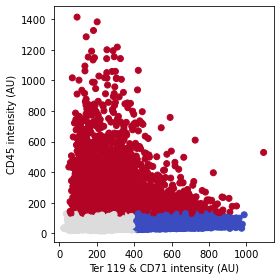

In [192]:
fig, ax = plt.subplots(figsize = (4,4))
plt.scatter(prop['mean_intensity_3'], prop['mean_intensity_2'], marker='o', c=prop['cell_type'], cmap=plt.cm.coolwarm)

ax.set_xlabel('Ter 119 & CD71 intensity (AU)')
ax.set_ylabel('CD45 intensity (AU)')

plt.tight_layout()

In [161]:
prop[prop.cell_type == 2].mean_intensity_2.mean()

435.2845546847271

In [188]:
prop.loc[prop.mean_intensity_2 > 130, 'cell_type'] = 2

In [193]:
n_0 = len(prop[prop.cell_type == 0])

print(n_0)

n_1 = len(prop[prop.cell_type == 1])

print(n_1)

n_2 = len(prop[prop.cell_type == 2])

print(n_2)


n_3 = len(prop[prop.cell_type == 3])

print(n_3)

10719
11869
3266
0


/home/pub/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


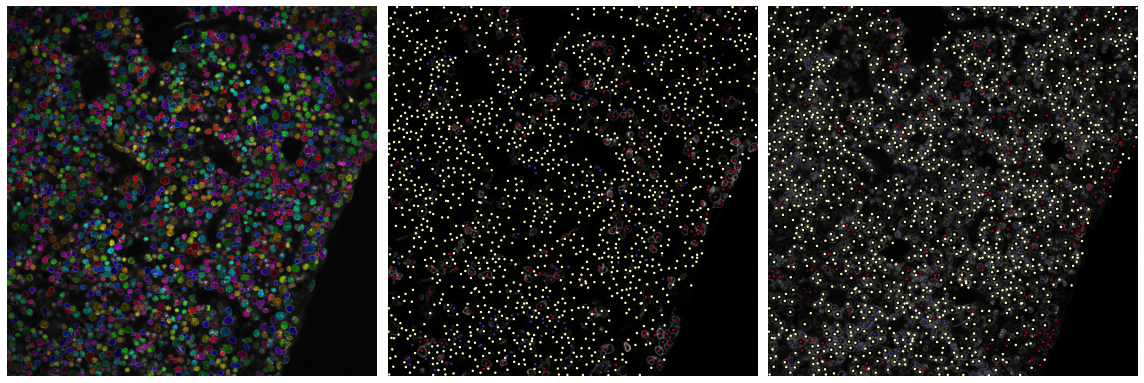

In [190]:
fig, ax = plt.subplots(1,3, figsize = (16,16))

z = 20

minx = 0
maxx = 1000
miny = 0
maxy = 1000

sample_plot = prop[(prop.cell_type > -1) &
                   (prop.z > z - 10) & (prop.z < z + 10) &
                   (prop.x > minx) & (prop.x < maxx) &
                   (prop.y > miny) & (prop.y < maxy)]

sample_plot.x -= minx
sample_plot.y -= miny


ax[0].imshow(cellpose.plot.mask_overlay(img_test_seg[z, minx:maxx, miny:maxy, 0], img_test_seg[z, minx:maxx, miny:maxy,4]))
ax[0].axis('off')

ax[1].imshow(img_test_seg[z, minx:maxx, miny:maxy,2], cmap = 'gray')
ax[1].scatter(sample_plot.y, sample_plot.x, c = sample_plot.cell_type, cmap = 'RdYlBu_r',s=2)
ax[1].axis('off')

ax[2].imshow(img_test_seg[z, minx:maxx, miny:maxy,3], cmap = 'gray')
ax[2].scatter(sample_plot.y, sample_plot.x, c = sample_plot.cell_type, cmap = 'RdYlBu_r',s=2)
ax[2].axis('off')

plt.tight_layout()

plt.savefig('voronoi_pipeline_results.pdf', dpi = 800)

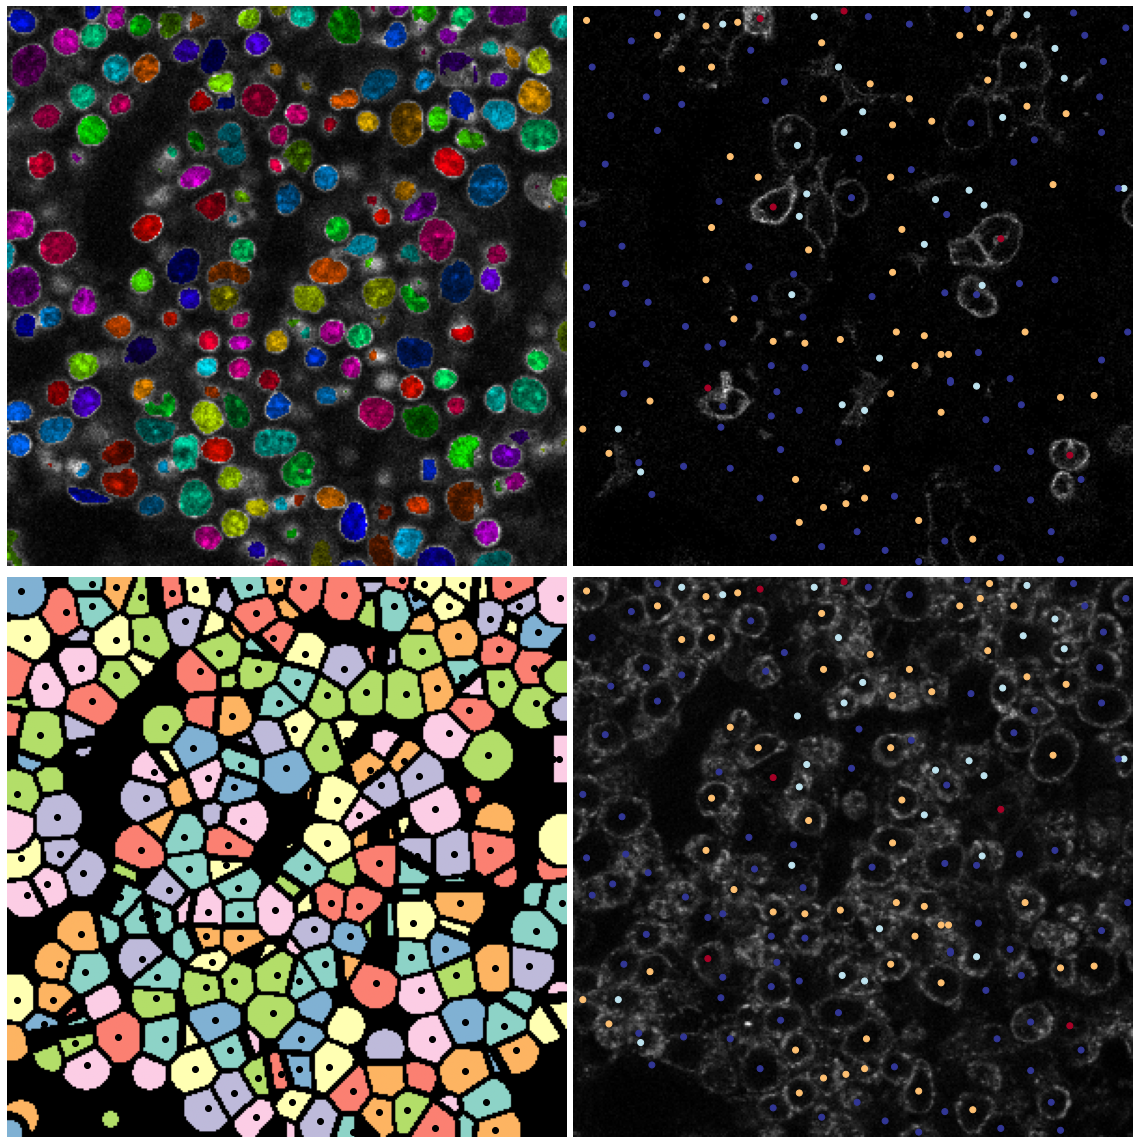

In [55]:
fig, ax = plt.subplots(2,2, figsize = (16,16))

z = 20

sample_plot = prop[(prop.cell_type > -1) &
                   (prop.z > z - 9) & (prop.z < z + 9)]

color_list = [plt.cm.Set3(i) for i in range(8)]
colors = [random.choice(color_list) for i in range(len(np.unique(voronoi[z,:,:])))]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=len(np.unique(voronoi[z,:,:])))

boundary_label_mask = find_boundaries(voronoi, connectivity=2)
vor_copy = np.copy(voronoi)
vor_copy[boundary_label_mask == 1] = 0

ax[0,0].imshow(cellpose.plot.mask_overlay(img_test_seg[z, ...,0], img_test_seg[z, ...,4]))
ax[0, 0].axis('off')

ax[1, 0].imshow(skimage.color.label2rgb(vor_copy[z,:,:],
                                     colors=colors,
                                     bg_label = 0))
ax[1, 0].scatter(sample_plot.y, sample_plot.x, c = 'k')
ax[1, 0].axis('off')

ax[0, 1].imshow(img_test_seg[z, ...,2], cmap = 'gray')
ax[0, 1].scatter(sample_plot.y, sample_plot.x, c = sample_plot.cell_type, cmap = 'RdYlBu_r')
ax[0, 1].axis('off')

ax[1,1].imshow(img_test_seg[z, ...,3], cmap = 'gray')
ax[1,1].scatter(sample_plot.y, sample_plot.x, c = sample_plot.cell_type, cmap = 'RdYlBu_r')
ax[1,1].axis('off')

plt.tight_layout()

plt.savefig('voronoi_pipeline_results.pdf')